# Abstract

Using data collected from hospitals in India, we demonstrate the usefulness of logistic regression in classifying patients with cardiovascular disease based on features collected by the hospital. We first present the classic approach to logistic regression (frequentist appraoch) followed by a demonstration of a bayesian approach to binary classification data. Our analysis shows that the given features and proposed inference approach prove viable and accurate methods in detecting cardiovascular disease in the sampled patients. 

Data can be found <a href="https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset">here</a>

# Introduction

Tests are widely used in hospitals around the world to increase the effectiveness of preventitve care. Behind these tests are statistical methods that aid doctors and other healthcare professionals in properly administering care by correctly identifying health problems. In this analysis, we analyze a dataset collected from hospitals in India that were looking for ways to identify cardiovascular diseases in their patients. The goal is to provide the hospitals with 2 things: an accurate model that predicts the presence of cardiovascular disease, and a model that helps doctors know what symptoms to watch out for when helping patients, further alerting them to either receive a test for possible cardiovascular disease or dismiss those concerns. 

Below is the first 5 rows of the dataset that we will be analyzing.

In [1]:
#| echo: false

#Import libraries
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
#| echo: false
### ONLY RUN ONCE ###
#Download dataset
#od.download("https://www.kaggle.com/datasets/jocelyndumlao/cardiovascular-disease-dataset")

In [3]:
#| echo: false

#Read in data
df = pd.read_csv("kaggle_datasets/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv")

In [4]:
#| echo: false

#Check data read in correctly
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


Of the 14 columns listed above, 1 is our target column (1 for disease and 0 for no disease), 12 features that we will use to gather inference on the target, and 1 column for patientids (unique key). Gender is encoded 1 for male and 0 for female. To ensure our analysis goes smoothly, we should validate that there are no null values. If there are any, we need to construct a strategy for conserving as much information as possible. Output for the number of null values for each column is found below.

In [5]:
#| echo: false

#Check for nulls
df.isna().sum()

patientid            0
age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

The output shows that there are no null values for any of the columns in our dataset, so we can move onto the next step of data prep which is to verify the datatypes of each column. Essentially, we are verifying that all columns have data values that are to be expected (i.e. integers types for numeric columns). Output for this test is shown below.

In [6]:
#| echo: false

#Check datatypes
df.dtypes

patientid              int64
age                    int64
gender                 int64
chestpain              int64
restingBP              int64
serumcholestrol        int64
fastingbloodsugar      int64
restingrelectro        int64
maxheartrate           int64
exerciseangia          int64
oldpeak              float64
slope                  int64
noofmajorvessels       int64
target                 int64
dtype: object

There doesn't appear to be any unexpected datatypes in the dataset, so we can verify this step of data prep. More data prep can always be explored to ensure viable data for data analysis purposes, but for now we shall conclude these 2 steps are sufficient and proceed to our analysis of the data.

In [7]:
#| echo: false

#Add gender label column for plotting purposes
df = df.assign(gender_label = lambda x: np.where(x.gender == 1, "Male", "Female"))

# Exploratory Data Analysis

To begin our analysis, we will perform exploratory data analysis (EDA) to gather more information about how to best model our data. Below is a descriptive statistics table for our columns.

In [8]:
#| echo: false

#Get descriptive stats
df.describe()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


Viewing the average for target, we get a value of .58, meaning a little more than half of our dataset contains presence of cardiovascular disease. Returning to the age column, we see that the average age is around 49 years, with the oldest being 80 and the youngest being 20. In addition, most of our dataset is compromised of males (about 77% of the dataset). Further domain knowledge is necessary to identify whether the other features respective statistics are "good" or "bad" values (healthy or not healthy).

While the tabular statistical information above is valiable, visual representations of the data are valiable to present so that we can quickly digest how our data looks. Below is a bar plot of the target values.

In [9]:
#| include: false

#Get dimensions
df.shape

(1000, 15)

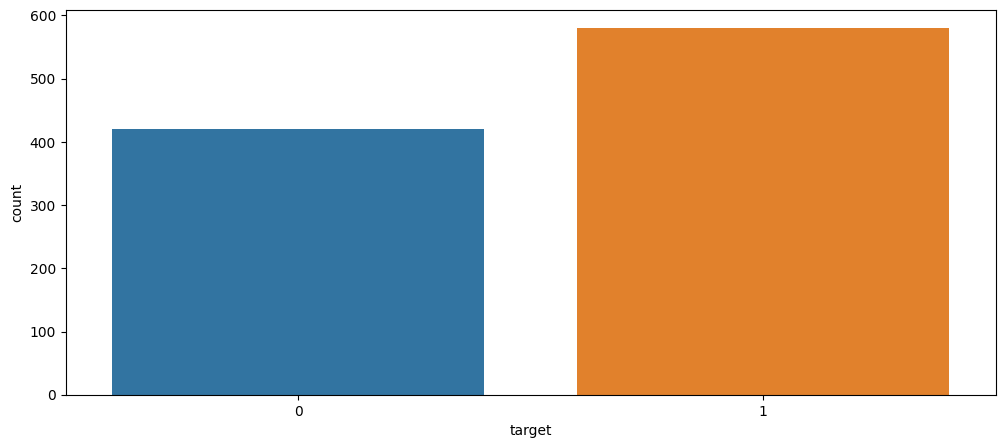

In [10]:
#| echo: false
#| label: fig-target-bar
#| fig-cap: "Bar plot of target count using seaborn. As noted from the summary statistics, the dataset contains more 1s than 0s for target, indicating a higher presence of heart disease in the sample." 

#Plot bar plot of split between 0s and 1s
plt.figure(figsize=(12,5))
sns.countplot(x='target', data=df);

We can now visually see the imbalance of data in our dataset. There appears to be about 150 more 1s than 0s in the dataset. We will demonstrate later in the analysis how logistic regression is a good choice for handling unbalanced datasets. For now, we will continue to explore the dataset. While we clearly see above that there is a difference between the number of patients with and without heart disease, we should discover more information about who pertains to each target value. To do this, we can use a box-and-whisker plot to view the distribution of a variable separated by target value. Below is a box-and-whisker plot of the age distribution for 0 and 1 target values respectively.

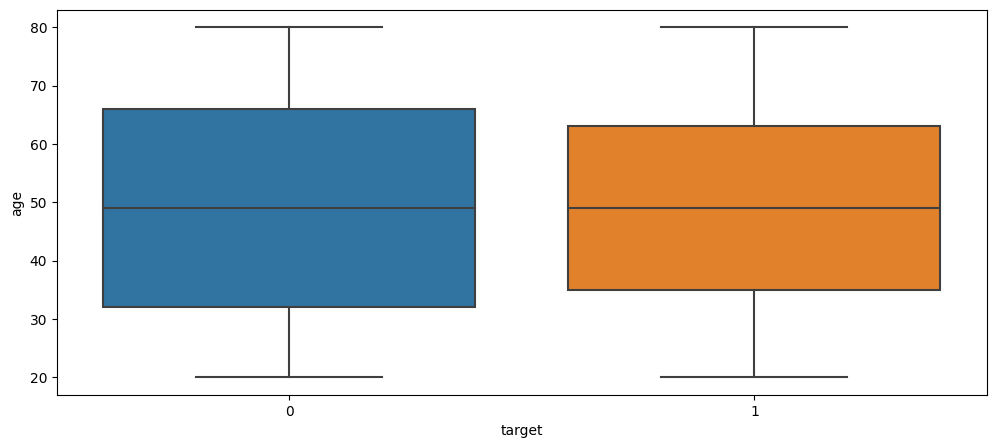

In [11]:
#| echo: false
#| label: fig-box-age
#| fig-cap: "Box-and-whisker plot of the distribution of age between the 2 target values. While the bar plot in @fig-target-bar showed a difference in the number of each target value, this plot shows there is no big difference in age distribution between the 2 target values."

#Check box plot of distribution between 0s and 1s and age
plt.figure(figsize=(12,5))
sns.boxplot(x='target', y='age', data=df);

The median for each respective target value appears to be 50, with a bit more variance for target value 0 than in target value 1, probably due to a smaller sample size. Nonetheless, we see that the age distribution for those who do not have and do have heart disease appear to be approximately the same. 

To speed up the process of EDA, we can plot several box-and-whisker plots to view distribution of many variables split by target value. @fig-box-many shows the distribution of other features in our dataset split by target value.

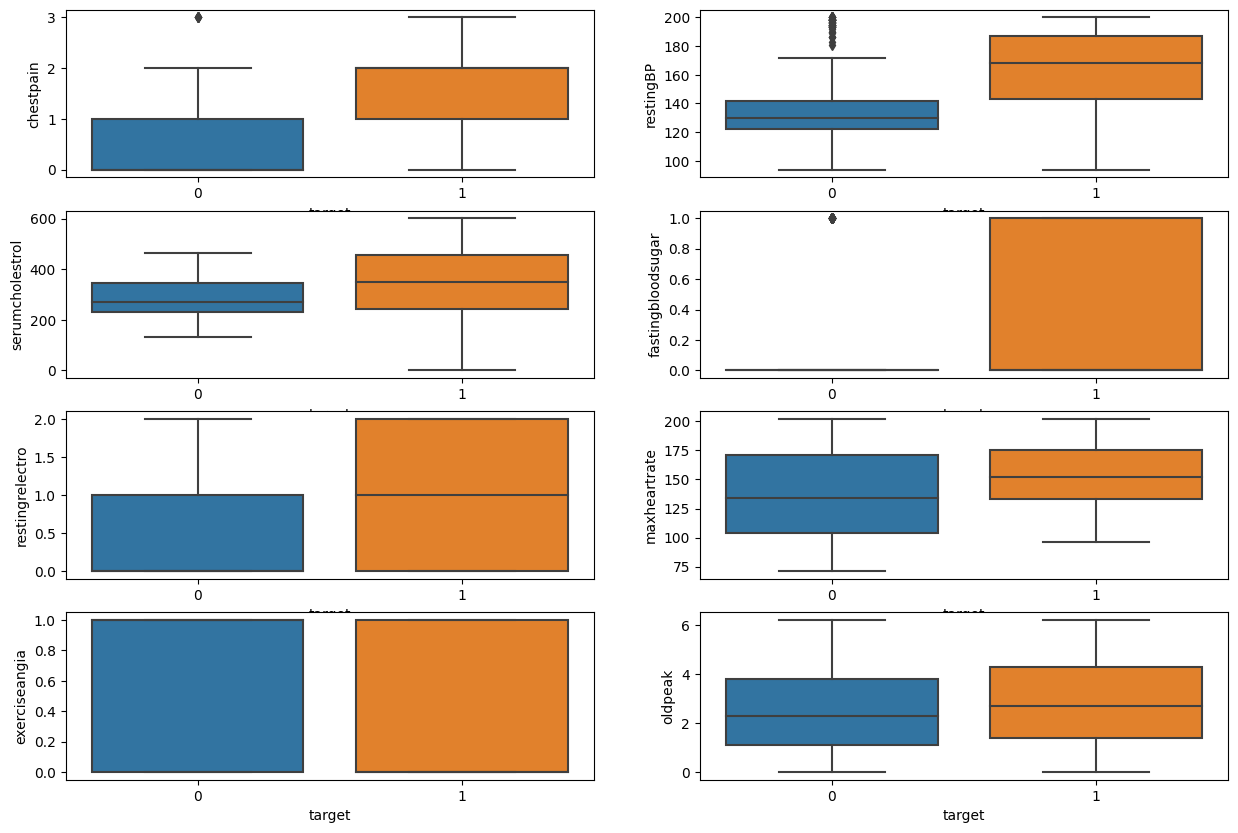

In [12]:
#| echo: false
#| label: fig-box-many
#| fig-cap: "A 4x2 grid of box-and-whisker plots to speed up EDA ingestion. There are a few features that appear to show differing distributions between target values, such as level of chest pain and resting BP."

#Check out box plots for more features between 0s and 1s
feat_list = df.columns[3:11].to_list()

#Instantiate subplots fig and axes
fig, axes = plt.subplots(4,2, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x='target', y=feat_list[i], data=df, ax=ax)

Viewing a grid of box-and-whisker plots allows us to quickly review the distributions for each target value for each feature specified. There appears to be a few features that have differing distributions, such as chestpain, restingBP, and fastingbloodsugar. Clearly delineated differences between target values will be useful for our logistic regression model in identifying patients with heart disease.

Using the information from @fig-box-many, we can create a scatterplot to explore more in-depth the relationship between these features with differing distributions. Below in @fig-scatterplot, we show a 1x2 grid scatterplot. The left hand panel is maxheartrate by serumcholestrol and the right hand panel is restingBP by serumcholestrol.

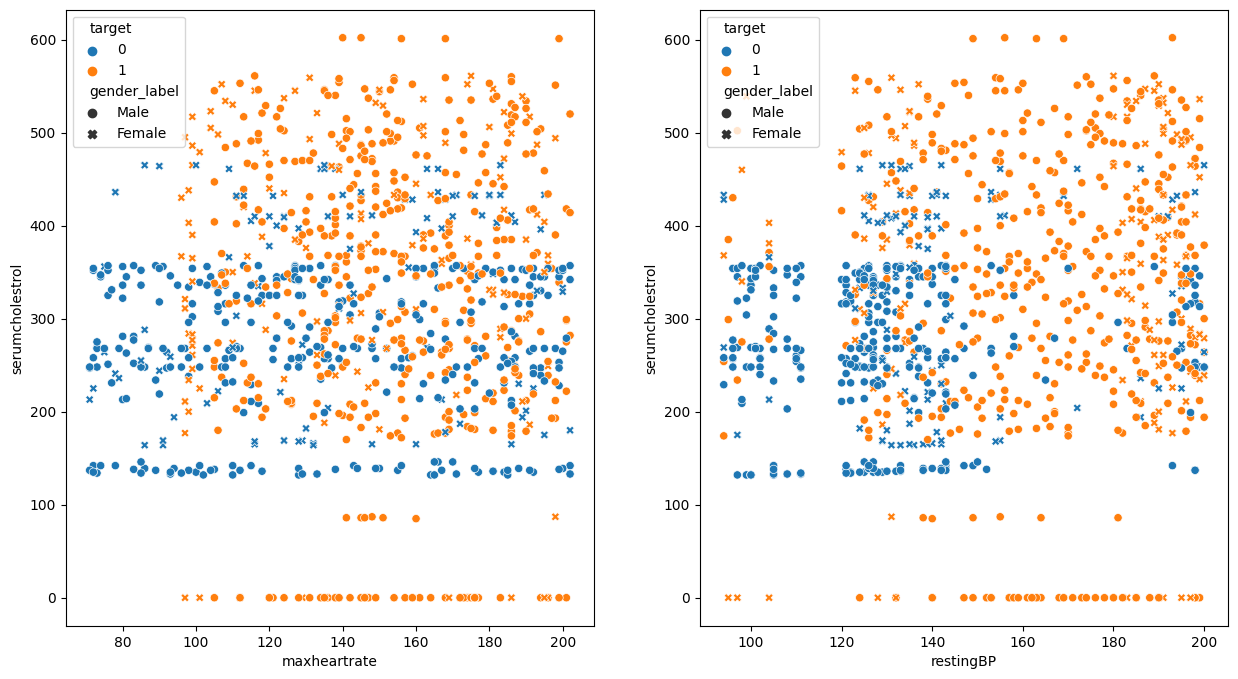

In [13]:
#| echo: false
#| label: fig-scatterplot
#| fig-cap: "Scatterplots showing 2 quantitative variables, colored by target and symbolized by gender. The left hand panel shows maxheartrate by serumcholestrol and the right hand panel shows restingBP by serumcholestrol."

#Check out scatterplot between maxheartrate and cholestrol and scatterplot between restingBP and cholestrol with hue target and style gender
fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(x='maxheartrate', y='serumcholestrol', hue='target', style='gender_label', data=df, ax=axes[0])
sns.scatterplot(x='restingBP', y='serumcholestrol', hue='target', style='gender_label', data=df, ax=axes[1]);

Looking at the left hand panel, we see that most of the 1 target values (heart disease) are either 0-100 or above 380ish. Most 0 values fall between 150-350ish on serumcholestrol. There does not appear to be any significant differenec between genders as they both appear to be intermixed fairly well. For the right hand panel, we see a more delineated difference for restingBP. There appears to be very few 0 values in the range of 140-200 restingBP. As well, Those above 140 restingBP and above 350 serumcholestrol appear to have a higher concentration of 1 target values. Additionally, there appears to be more males within the range of 140-180 restingBP who have target value of 1 whereas females who have a target value of 1 have a higher restingBP, more towards the range of 180-200 restingBP.

To explore the relationship of presence of heart disease and chestpain and noofmajorvessels, we can use countplots split by target value for each resepective level of chestpain and noofmajorvessels. 

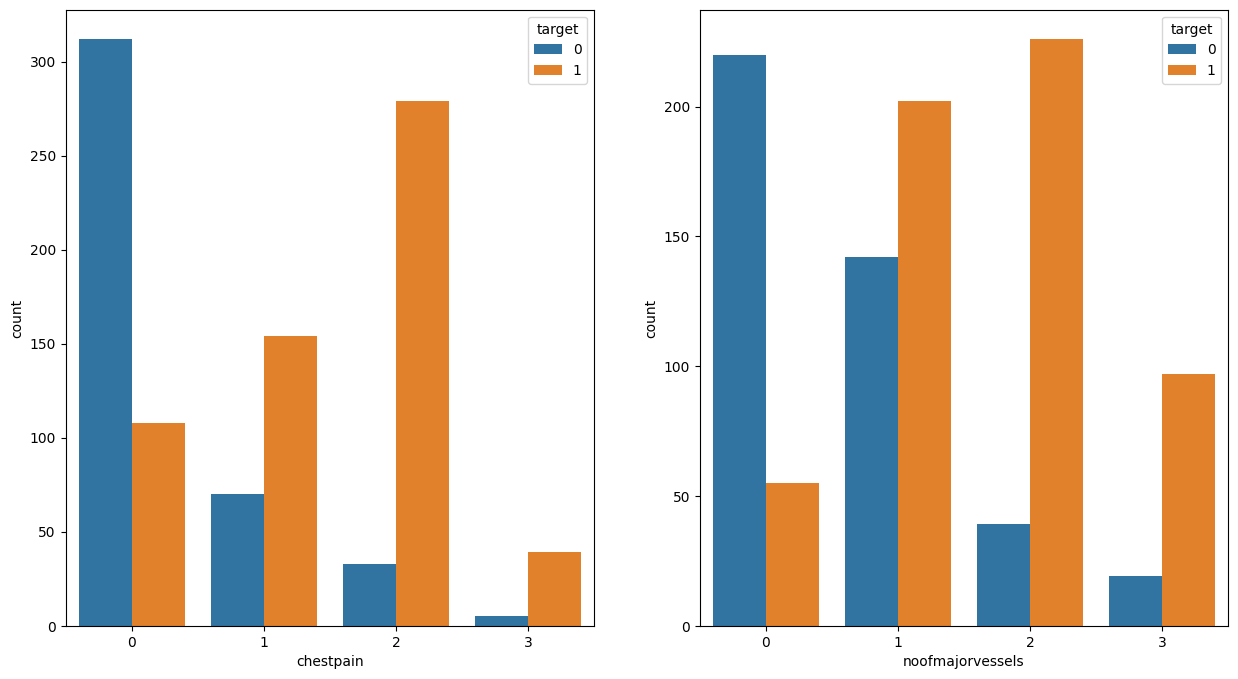

In [14]:
#| echo: false
#| label: fig-count-plot
#| fig-cap: "A 1x2 grid of countplots. The left hand panel shows the counts for each bucket of chestpain split by target value. The right hand panel shows the counts for each bucket of noofmajorvessels split by target value."

#Plot count plots of those with chestpain, noofmajorvessels by target and then gender
fig, axes = plt.subplots(1,2, figsize=(15,8))

sns.countplot(x='chestpain', hue='target', data=df, ax=axes[0])
sns.countplot(x='noofmajorvessels', hue='target', data=df, ax=axes[1]);

In the left hand panel of @fig-count-plot, we see that as the level of chest pain increases, the proportion of those who have heart disease increase. Additionally, in the right hand panel, as we increase in noofmajorvessels, there is a greater proprotion of those who have heart disease. 

In [15]:
#| include: false

#Correlation matrix
df.iloc[:, 1:13].corr()

,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels
age,1.000000,-0.024717,0.037731,-0.016126,0.035439,0.049732,0.067736,-0.040092,-0.037581,-0.026020,-0.015334,0.025407
gender,-0.024717,1.000000,0.035402,-0.069727,-0.120759,0.023560,-0.046634,0.064606,-0.051746,0.331457,-0.051957,0.029376
chestpain,0.037731,0.035402,1.000000,0.222267,0.174731,0.232059,0.256316,0.114496,-0.027376,0.101345,0.472731,0.285156
restingBP,-0.016126,-0.069727,0.222267,1.000000,0.126523,0.192063,0.219887,0.095569,-0.046545,-0.004225,0.376711,0.263194
serumcholestrol,0.035439,-0.120759,0.174731,0.126523,1.000000,0.278337,0.101767,0.038967,0.029422,-0.025910,0.165569,0.132419
fastingbloodsugar,0.049732,0.023560,0.232059,0.192063,0.278337,1.000000,0.143982,0.096528,0.011356,0.015311,0.242734,0.182246
restingrelectro,0.067736,-0.046634,0.256316,0.219887,0.101767,0.143982,1.000000,0.099991,-0.032489,0.040291,0.343280,0.204684
maxheartrate,-0.040092,0.064606,0.114496,0.095569,0.038967,0.096528,0.099991,1.000000,0.015536,0.044614,0.201515,0.122763
exerciseangia,-0.037581,-0.051746,-0.027376,-0.046545,0.029422,0.011356,-0.032489,0.015536,1.000000,-0.003296,-0.017783,-0.017513
oldpeak,-0.026020,0.331457,0.101345,-0.004225,-0.025910,0.015311,0.040291,0.044614,-0.003296,1.000000,0.208789,0.086992


# Verify Model Assumptions

In order to properly model this data using logistic regression, we need to verify a few assumptions. First, we need to verify that our observations are independent of one another, that is that no observation mathematically influences any other observation. Thinking logically, we can verify this assumption that someone's restingBP does not affect any other restingBP, and so forth for every feature found in the dataset. Therefore, we can model our dataset as shown in @eq-bern.

$$
X_1, ... ,X_n \sim \text{ i.i.d. Bernoulli(p)} 
$${#eq-bern}

In [16]:
#| echo: false

#Split features and target
X = df.drop(['patientid', 'target', 'gender_label'], axis=1)
y = df[['target']]

The second assumption we should verify is that of multicollinearity. Multicollinearity occurs when features of a dataset are highly correlated with one another. This results in variance inflation which throws off the standard errors used in statistical modeling calculations. Below are the respective VIF scores for each feature in the dataset.

In [17]:
#| echo: false

#Verify multicolinearity assumption
vif = (pd.DataFrame()
       .assign(vif_factor = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])])
       .assign(features = X.columns))
print(vif)

    vif_factor           features
0     7.407596                age
1     4.817933             gender
2     2.769973          chestpain
3    19.558195          restingBP
4     6.841284    serumcholestrol
5     1.631514  fastingbloodsugar
6     2.275207    restingrelectro
7    15.313735       maxheartrate
8     1.957391      exerciseangia
9     4.107705            oldpeak
10    6.588688              slope
11    3.622189   noofmajorvessels


A general rule of thumb is that VIF scores above 10 should be eliminated. Therefore, we will remove restingBP and maxheartrate from the dataset in order to verify the assumption of multicollinearity.

In [18]:
#| echo: false

#Recalculate vif based on dropped values
X = df.drop(['patientid', 'target', 'gender_label', 'restingBP', 'maxheartrate'], axis=1)

vif = (pd.DataFrame()
       .assign(vif_factor = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])])
       .assign(features = X.columns))
print(vif)

   vif_factor           features
0    5.686277                age
1    4.227614             gender
2    2.769430          chestpain
3    5.649147    serumcholestrol
4    1.629010  fastingbloodsugar
5    2.247908    restingrelectro
6    1.883431      exerciseangia
7    4.075928            oldpeak
8    6.053960              slope
9    3.597850   noofmajorvessels


As we can see above in the new VIF scores, none of the scores are above 10 so we will accept these features as passed for the multicollinearity assumption. 

The last assumption we will verify for our logistic regression model is the linearity assumption, or better said, the monotonicity assumption. We assume that each feature has a monotonic relationship with the target (response) variable. Below, we view this relationship in @fig-mono-plot

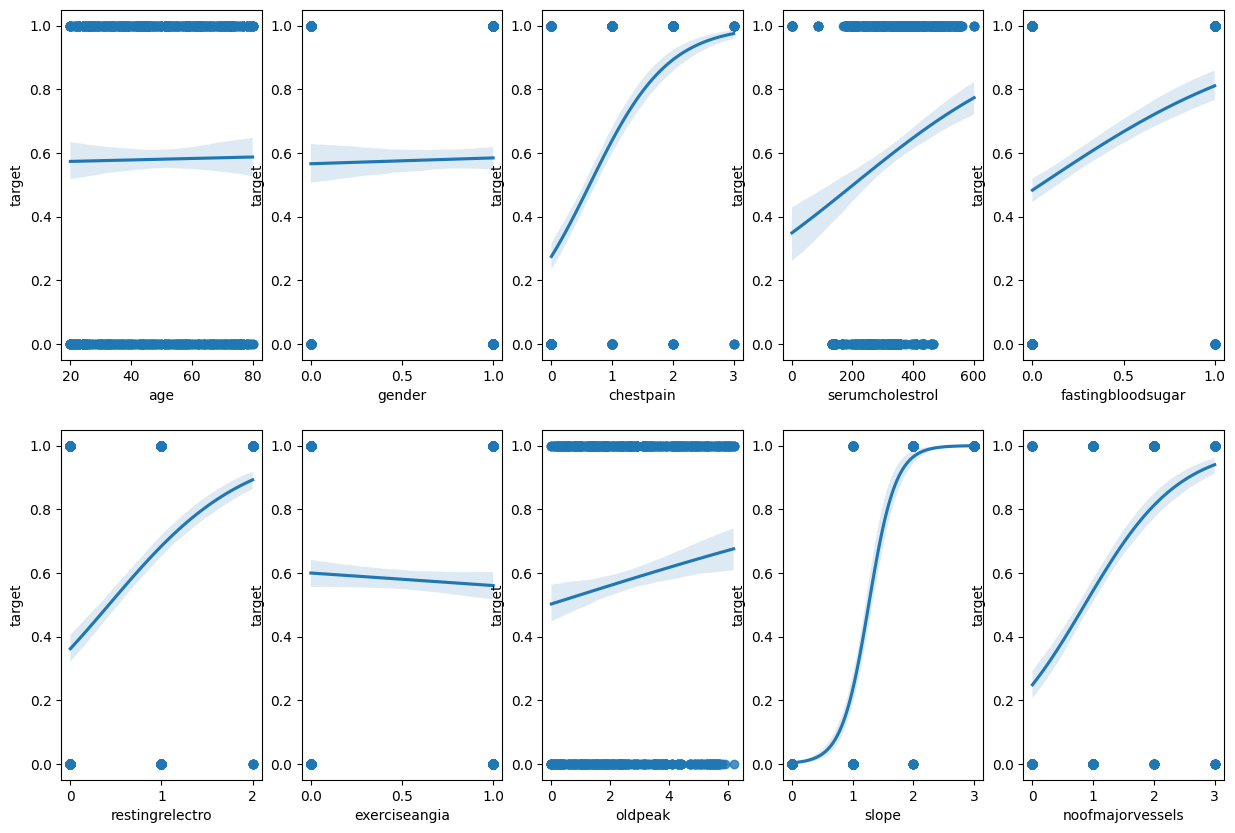

In [19]:
#| echo: false
#| label: fig-mono-plot
#| fig-cap: "A 2x5 grid of logistic regression plots, modeling the relationship between a given feature and the target variable. Each feature should have an approximate monotonic relationship with the target variable in order to verify the assumption of monotonicity."

#Verify linearity assumption
fig, axes = plt.subplots(2,5, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):
    sns.regplot(x=X.columns[i], y='target', data=df, ax=ax, logistic=True)

From @fig-mono-plot, we see that each plot demonstrates a monotonic-esque relationship. Therefore, we can verify the monotonicity assumption.

# Model Creation

Using @eq-bern, we can model our data using the <em>logit</em> function to create a linear relationship with the betas and features and the log-odds of the data. This relationship is shown in @eq-log-model.

$$
\text{log}(\frac{p(X)}{1-p(X)}) = \beta_0 + \beta_1x_1 ... + \beta_px_p
$${#eq-log-model}

In [20]:
#| echo: false

#Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [21]:
#| echo: false

#Instantiate logistic regression model using statsmodels
log_glm = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial()).fit()

After fitting @eq-log-model to our data, we obtain the below results. 

In [22]:
#| echo: false

#Print results of model
print(log_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  750
Model:                            GLM   Df Residuals:                      739
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78.442
Date:                Fri, 12 Jan 2024   Deviance:                       156.88
Time:                        12:38:31   Pearson chi2:                     349.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.6830
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.4812      1.36

In the results above, of the features in the dataset fitted to the model, 5 of them are statistically significant (gender, chestpain, restingelectro, oldpeak, and slope). Of those 5 stat sig. features, only 1 of them has an average negative log-odds effect on classification of heart-disease (oldpeak).

While viewing these betas in their log-odds form is helpful to indicate whether a feature positively or negatively influence the classification of heart-disease, transforming these values into probabilities may be easier to interpret. Below, we transform the betas to probabilities.

In [23]:
#| echo: false

#View coefficients in probability form
np.exp(log_glm.params) / (1 + np.exp(log_glm.params))

const                0.000028
age                  0.499799
gender               0.923852
chestpain            0.774311
serumcholestrol      0.500289
fastingbloodsugar    0.702057
restingrelectro      0.775258
exerciseangia        0.408566
oldpeak              0.237940
slope                0.999181
noofmajorvessels     0.544604
dtype: float64

For example, on average, an increase of 1 in slope results in a .99 factor increase of having heart disease, holding all else constant. It appears that slope and gender have the highest probability factor increase in having heart disease. Let us use these factors to see what the model would predict for the following mock data set: male, age 25, no chest pain, 100 serum cholestrol, 0 fasting blood sugar, resting electro 0, exerciseangia 0, oldpeak 1, slope 0, and noofmajorvessels 0.

In [24]:
#| echo: false

#Predict for mock test set above
mock_test = pd.DataFrame({'const': [1], 'age': [25], 'gender': [1], 'chestpain': [0], 'serumcholestrol': [100], 
                         'fastingbloodsugar': [0], 'restingelectro': [0], 'exerciseangia': [0], 
                         'oldpeak': [1], 'slope': [0], 'noofmajorvessels': [0]})

print("Log-odds: ", round(log_glm.predict(mock_test).values[0], 6))
print("Odds-ratio: ", round(np.exp(log_glm.predict(mock_test)).values[0], 6))
print("Probability: ", round(np.exp(log_glm.predict(mock_test)) / (1 + np.exp(log_glm.predict(mock_test))), 6).values[0])

Log-odds:  0.000117
Odds-ratio:  1.000117
Probability:  0.500029


The results above show that our model precicts, on average, that a person with the above characteristics would have an odds-ratio of about 1, or a probability of about 50% of having heart disease. Some may be confused by this result, as the above parameters show increases in probability that should result in a value closer than 1 for an additive model. However, one must remember that it is an additive model by logit (see @eq-log-model). To obtain probabilities, we have to inverse the logit function to isolate $p(X)$, as shown in @eq-log-prob. 

$$
p(X) = \frac{e^{\beta_0 + \beta_1x_1 ... + \beta_px_p}}{1 + e^{\beta_0 + \beta_1x_1 ... + \beta_px_p}}
$${#eq-log-prob}

# Model Assessment

As shown above, our logistic regression model now has predictive capabilties after being fit to the data. In order to gather a general idea of how well it does on testing data, we will perform a validation test set approach, where we withhold 25% of the data to be our test set and 75% of our data will be used as training data for the model. Afterwards, we can evaluate the predictive capability of our model by assessing its roc curve and auc score. These can be found in @fig-roc-plot

In [25]:
#| echo: false

#Create predictions from model
y_preds = log_glm.predict(sm.add_constant(X_test))

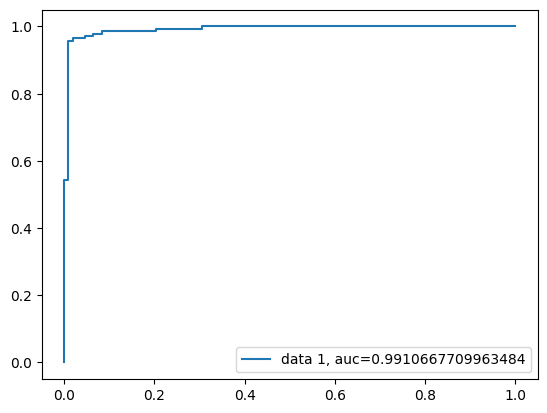

In [26]:
#| echo: false
#| label: fig-roc-plot
#| fig-cap: "ROC curve showing how the logistic regression model performed on the test set, with corresponding auc score in bottom right-hand corner of plot."

#Plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_preds)
auc = metrics.roc_auc_score(y_test, y_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Our ROC curve in @fig-roc-plot shows a nice elbow feature, indicating that our model performs very well at indicating true positives. In addition, our AUC score of .99 shows that our model performs very well at distinguishing between the true positives and false positives, meaning we have very good predictive performance in our logistic regression model. Using these metrics, we can find the optimal classification threshold that maximizes the true positive rate and minimizes that false positive rate. Below is our optimal threshold.

In [27]:
#| echo: false

#Identify optimal threshold
optimal_thresh = thresholds[np.argmax(tpr - fpr)]
print(optimal_thresh)

0.6519052347690012


Our optimal threshold of approximately .65 indicates that we would classify anyone with a probability of heart disease above 65% as 1 (having heart disease) and anyone below 65% probability will be classified as 0 (no heart disease). We can use this value on our test set to create a confusion matrix and see the exact number of true positives and false positives. We can then utilize those numbers to calculate other metrics for model assessment such as sensitivity and specificity. The confusion matrix is found in @fig-conf-mat. 

In [28]:
#| echo: false

#Evaluate predictions by comparing labels
y_preds_labels = np.zeros(len(y_preds))
y_preds_labels[y_preds > optimal_thresh] = 1

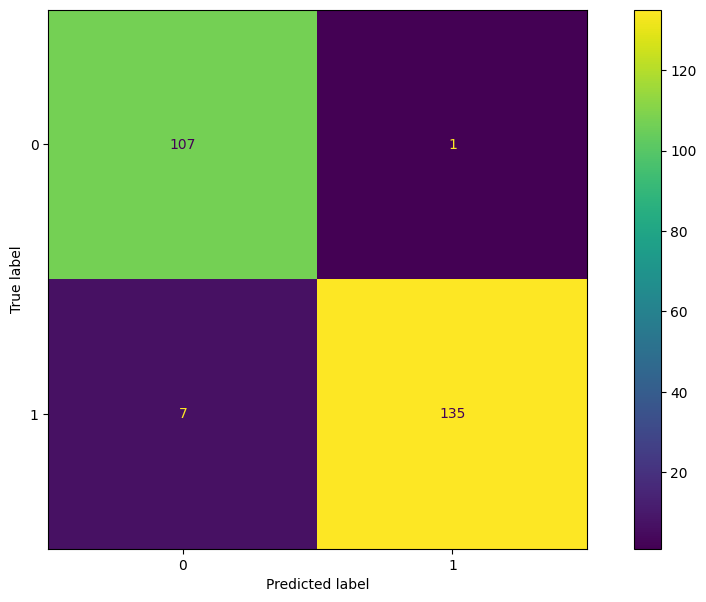

In [29]:
#| echo: false
#| label: fig-conf-mat
#| fig-cap: "Confusion matrix for our logistic regression model. The y axis indicates the true labels of the data and the x axis indicate the predicted label from our model."

#Create confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_preds_labels)
cm_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

fig, ax = plt.subplots(figsize=(12,7))
cm_plot.plot(ax=ax);

As we can see in the confusion matrix, our model does a great job at predicting true positives and true negatives. The model only mispredicted 1 true negative (generated 1 false negative) and mispredicted 7 true positives (generated 7 false positives). As mentioned above, we can use these numbers to view just how well our model does at identifying true positives and true negatives. Below are the metrics we calculated.

In [30]:
#| echo: false

#Calculate classification metrics

print("Accuracy: ", np.mean(y_test.target.to_numpy() == y_preds_labels))
print("Sensitivity: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0]), 4))
print("Specificity: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[0,1]), 4))
print("PPV: ", round(confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1]), 4))
print("NPV: ", round(confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[1,0]), 4))

Accuracy:  0.968
Sensitivity:  0.9507
Specificity:  0.9907
PPV:  0.9926
NPV:  0.9386


As shown above, even in our inbalanced data set, we achieved an accuracy of about 97%. Additionally, our sensitivity shows our model is very good at identifying true positives, scoring about 95%. Our specificity score was even better, scoring a 99%, meaning our model is almost perfect at identifying those who do not have the disease (true negatives). Positive predictive value and negative predictive value also prove to be very good, with 99% and 93% respectively. For PPV, this means the probability someone has the disease, given that they tested positive (classified as a 1), is 99%. For NPV, this means the probability someone doesn't have the disease, given they tested negative (classified as a 0), is 93%. 

This numbers, when we take into account our threshold value (.65), makes sense since we classify people with heart disease if and only if they are above 65% probability. Otherwise, they are classified as not having heart disease. For reference on how we calculated the above values, see @eq-conf-met.

$$
Sensitivity = \frac{TP}{TP+FN}
$$

$$
Specificity = \frac{TN}{TN+FP}
$$

$$
PPV = \frac{TP}{TP+FP}
$$

$$
NPV = \frac{TN}{TN+FN}
$${#eq-conf-met}

# Bayesian Model Creation